# Dogs vs Cats Redux - Kaggle Pre Built VGG()

In this notebook, we will explore how we can use a pre-trained VGG network to classify images as either dogs or cats. We will then submit our predictions to this kaggle competition:

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data

In this notebook, I am trying the following models : 
    - Prebuilt VGG With Fully Connected Layers On Top
    - Prebuilt VGG Without Dropout and With BatchNormalization
    - Prebuilt VGG With Low Dropout and BatchNormalization
    - Ensemble of Prebuilt VGG With Low Dropout and BatchNormalization
    - Prebuilt VGG with Fully Connected Convolution Layers - No Dense Layers

## Imports

In [1]:
from importlib import reload
from PIL import Image
#from IPyth import 

In [2]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Input, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Activation
from keras.optimizers import Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from importlib import reload
from keras import backend as K

np.random.seed(7)

Using TensorFlow backend.


In [3]:
from __future__ import division,print_function

import bcolz
from IPython.display import FileLink
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

## Directory structure of the data

In Keras, for image recognition/classification, we need to arrange the data in a certain structure (i.e, if we suethe flow_from_directory method of ImageDataGenerator). Images from each category for training must be placed in a separate folder. 

Here, we have two separate folders 'cats' and 'dogs' each of which contains training examples belonging to that class. We do the same for validation set. 

Since the test set examples are unlabeled (as we are to predict them), we put all those examples into an 'unknown' folder.

NOTE : This fixed directory structure was created from the command line and this code for it is not present in this notebook. Code for directory structure creation will be added to future notebooks

In [4]:
PATH = 'data/dogscatsredux/'
MODEL_PATH = PATH + 'models/'
TRAIN_PATH = PATH + 'train/'
VALID_PATH = PATH + 'valid/'
TEST_PATH = PATH + 'test/'
RESULT_PATH = PATH + 'results/'

In [5]:
% ls 'data/dogscatsredux/'

models/  results/  sample/  sample_submission.csv  test/  train/  valid/


In [6]:
% ls 'data/dogscatsredux/test'

unknown/


In [7]:
% ls 'data/dogscatsredux/train'

cats/  dogs/


In [8]:
% ls 'data/dogscatsredux/valid'

cats/  dogs/


Let us now see a few of these images

In [9]:
%ls -U 'data/dogscatsredux/train/cats' | head -4

cat.8760.jpg
cat.710.jpg
cat.1069.jpg
cat.11298.jpg
ls: write error


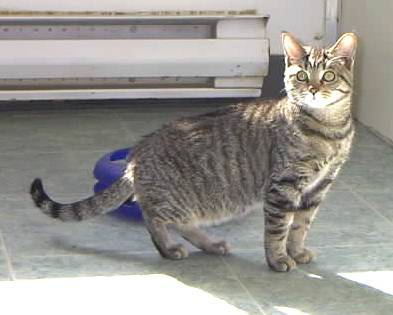

In [10]:
ex_path = TRAIN_PATH+'cats/'
Image.open(ex_path + 'cat.8760.jpg')

As we can see, the directory structure is in the format needed by keras

## Load VGG Model

In the cell below, I am forcing Keras to use the 'channels_last' image data format since my backend is tensorflow. This would be set to 'channels_first' for Theano backend

In [11]:
K.set_image_data_format("channels_last")

In [12]:
img_height, img_weidth = 224,224

One of the cool things about Keras is that it has deep learning models that are made available alongside pre-trained weights. These models are the ones which have won ImageNet over the years.

Another convivient option given by these Keras application APIs' is whether to include the fully connected dense layersm present at the top of the model, or not. 

We are not including those layers since we want to finetune our model to the Dogs vs Cats task.

Reference : https://keras.io/applications/

In [13]:
base_model = VGG16(weights = 'imagenet', include_top = False, input_shape=(img_height,img_weidth,3))


In [14]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Save output of base model

We have imported the vgg16 model's preprocess_input method. This we are passing as an argument to the ImageDataGenerator since we want the input to be pre-processed VGG16 style.

In [15]:
gen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size = 64

**IMPORTANT NOTE**

In this case, shuffle *needs* to be False since we want to extract the labels in the order that they are predicted

In [16]:
train_batches = gen.flow_from_directory(directory=TRAIN_PATH,target_size=(img_weidth,img_height),\
                                        class_mode='categorical',batch_size=batch_size,\
                                        shuffle=False)

Found 20000 images belonging to 2 classes.


In [17]:
valid_batches = gen.flow_from_directory(directory=VALID_PATH,target_size=(img_weidth,img_height),\
                                        class_mode='categorical',batch_size=batch_size,\
                                        shuffle=False)

Found 5000 images belonging to 2 classes.


In [18]:
test_batches = gen.flow_from_directory(directory=TEST_PATH,target_size=(img_weidth,img_height),\
                                        class_mode='categorical',batch_size=batch_size,\
                                        shuffle=False)

Found 12500 images belonging to 1 classes.


In [19]:
valid_classes = valid_batches.classes
train_classes = train_batches.classes

#We need to convert the labels into one-hot-encoded form since the loss function is 'categorical_crossentropy'
valid_labels = to_categorical(valid_classes)
train_labels = to_categorical(train_classes)

**IMPORANT NOTE** : **Saving output of base model**

We're going to be training a number of iterations for a bunch of differerent fully connected layers. 

So it would be best for us to pre-calculate the output of our base model (and thus all its convolution layers) which will then be fed as input to the fully connected layers (which we will be adding later on top of our base model). 

This will help us save time since our computation would have to go through the base model only once. (This computation would be the same for every different model we add on top of our base model.) Hence it makes sense to store the output of the base model.

The other alternative to this was to just add our fully connected layer model on top of the base model itself. Then set the base model layers to not be trainable and just train the newly added dense layers. However this would be computationally inefficient since our calculations would go again and again through the base model layers too.

In [21]:
train_steps = int(np.ceil(train_batches.n/batch_size))
validation_steps = int(np.ceil(valid_batches.n/batch_size))
test_steps = int(np.ceil(test_batches.n/batch_size))

In [29]:
valid_features_to_dense = base_model.predict_generator(valid_batches, validation_steps, verbose=1)

79/79 [==============================] - 60s 760ms/step


In [30]:
train_features_to_dense = base_model.predict_generator(train_batches, train_steps, verbose=1)

313/313 [==============================] - 212s 679ms/step


In [46]:
test_features_to_dense = base_model.predict_generator(test_batches, test_steps, verbose=1)

196/196 [==============================] - 152s 777ms/step


We can save these arrays to a file so that we can simply load them up the next time we run the notebook and save time.

In [24]:
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()


def load_array(fname):
    return bcolz.open(fname)[:]

In [32]:
save_array(MODEL_PATH + 'train_vgg_maxpool_layer_features.bc', train_features_to_dense)
save_array(MODEL_PATH + 'train_vgg_maxpool_layer_labels.bc', train_labels)

save_array(MODEL_PATH + 'valid_vgg_maxpool_layer_features.bc', valid_features_to_dense)
save_array(MODEL_PATH + 'valid_vgg_maxpool_layer_labels.bc', valid_labels)

In [47]:
save_array(MODEL_PATH + 'test_vgg_maxpool_layer_features.bc', test_features_to_dense)

In [25]:
train_features_to_dense = load_array(MODEL_PATH+'train_vgg_maxpool_layer_features.bc')
train_labels = load_array(MODEL_PATH+'train_vgg_maxpool_layer_labels.bc')

valid_features_to_dense = load_array(MODEL_PATH+'valid_vgg_maxpool_layer_features.bc')
valid_labels = load_array(MODEL_PATH+'valid_vgg_maxpool_layer_labels.bc')

In [26]:
test_features_to_dense = load_array(MODEL_PATH + 'test_vgg_maxpool_layer_features.bc')

## Add fully connected layer to top of base model

Now that we have the output of our base model, we can add the fully connected layer model on top of that.

The model we are adding below is exactly same as VGG16 except for the fact that the last dense layer has 2 outputs instead of 1000 as was the case with VGG16

In [22]:
inp = Input(shape=base_model.output_shape[1:])
x = Flatten()(inp)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation = 'softmax')(x)

new_model = Model(inp, predictions)
new_model.compile(optimizer=RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 8194      
Total para

In [23]:
new_model.optimizer.lr = 1e-6
new_model.fit(train_features_to_dense, train_labels, epochs=4, 
             batch_size=batch_size*4, validation_data=(valid_features_to_dense, valid_labels))

Train on 20000 samples, validate on 5000 samples
Epoch 1/4
20000/20000 [==============================] - 15s 764us/step - loss: 3.9539 - acc: 0.6696 - val_loss: 0.4753 - val_acc: 0.9272
Epoch 2/4
20000/20000 [==============================] - 14s 686us/step - loss: 2.1266 - acc: 0.8112 - val_loss: 0.3032 - val_acc: 0.9582
Epoch 3/4
20000/20000 [==============================] - 14s 684us/step - loss: 1.4342 - acc: 0.8707 - val_loss: 0.2471 - val_acc: 0.9686
Epoch 4/4
20000/20000 [==============================] - 14s 683us/step - loss: 1.1281 - acc: 0.8968 - val_loss: 0.2183 - val_acc: 0.9732


Running for a few more epochs ...

In [24]:
new_model.optimizer.lr = 1e-6
new_model.fit(train_features_to_dense, train_labels, epochs=4, 
             batch_size=batch_size*4, validation_data=(valid_features_to_dense, valid_labels))

Train on 20000 samples, validate on 5000 samples
Epoch 1/4
20000/20000 [==============================] - 14s 687us/step - loss: 0.8992 - acc: 0.9181 - val_loss: 0.2065 - val_acc: 0.9756
Epoch 2/4
20000/20000 [==============================] - 14s 683us/step - loss: 0.7840 - acc: 0.9269 - val_loss: 0.1922 - val_acc: 0.9764
Epoch 3/4
20000/20000 [==============================] - 14s 682us/step - loss: 0.7355 - acc: 0.9319 - val_loss: 0.1850 - val_acc: 0.9778
Epoch 4/4
20000/20000 [==============================] - 14s 683us/step - loss: 0.6577 - acc: 0.9398 - val_loss: 0.1736 - val_acc: 0.9790


A few more epochs ...

In [25]:
new_model.optimizer.lr = 1e-6
new_model.fit(train_features_to_dense, train_labels, epochs=4, 
             batch_size=batch_size*8, validation_data=(valid_features_to_dense, valid_labels))

Train on 20000 samples, validate on 5000 samples
Epoch 1/4
20000/20000 [==============================] - 10s 504us/step - loss: 0.5791 - acc: 0.9471 - val_loss: 0.1689 - val_acc: 0.9796
Epoch 2/4
20000/20000 [==============================] - 10s 500us/step - loss: 0.5798 - acc: 0.9453 - val_loss: 0.1643 - val_acc: 0.9800
Epoch 3/4
20000/20000 [==============================] - 10s 501us/step - loss: 0.5285 - acc: 0.9511 - val_loss: 0.1608 - val_acc: 0.9810
Epoch 4/4
20000/20000 [==============================] - 10s 501us/step - loss: 0.5093 - acc: 0.9533 - val_loss: 0.1600 - val_acc: 0.9808


## VGG like model without Dropout and with Batch Normalization

As we can see, our train accuracy is low compared to the validation accuracy. This means we are underfitting the data. This might be the case since we have dropouts of 0.5 after each dense layer. Now that would have worked for VGG16 since they had 1000 classes. But this value might be a bit higher for us since we just have 2 classes. 

Another important task we can do is to add BatchNormalization layers. BatchNormalization leads to faster convergence and prevents any particular activation from blowing out of scale. Why didnt VGG16 have it? Because it wasn't discovered by then :).


In [39]:
inp = Input(shape=base_model.output_shape[1:])
x = Flatten()(inp)
x = Dense(4096, activation='relu')(x)
x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
predictions = Dense(2, activation = 'softmax')(x)

vgg_like_wo_dr_w_bn = Model(inp, predictions)
vgg_like_wo_dr_w_bn.compile(optimizer=RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])
vgg_like_wo_dr_w_bn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
batch_normalization_1 (Batch (None, 4096)              16384     
_________________________________________________________________
dense_8 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
batch_normalization_2 (Batch (None, 4096)              16384     
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 8194      
Total para

In [40]:
vgg_like_wo_dr_w_bn.optimizer.lr = 1e-3
vgg_like_wo_dr_w_bn.fit(train_features_to_dense, train_labels, epochs=4, 
             batch_size=batch_size*8, validation_data=(valid_features_to_dense, valid_labels))

Train on 20000 samples, validate on 5000 samples
Epoch 1/4
20000/20000 [==============================] - 11s 554us/step - loss: 0.3037 - acc: 0.9528 - val_loss: 0.3144 - val_acc: 0.9762
Epoch 2/4
20000/20000 [==============================] - 10s 508us/step - loss: 0.1042 - acc: 0.9806 - val_loss: 0.2106 - val_acc: 0.9818
Epoch 3/4
20000/20000 [==============================] - 10s 508us/step - loss: 0.0849 - acc: 0.9855 - val_loss: 0.3439 - val_acc: 0.9748
Epoch 4/4
20000/20000 [==============================] - 10s 507us/step - loss: 0.0572 - acc: 0.9900 - val_loss: 0.2030 - val_acc: 0.9828


Running for a few more epochs ...

In [41]:
checkpointer = ModelCheckpoint(filepath=MODEL_PATH+'VGG16_LIKE_WO_DR_W_BN' + 'WEIGHTS.{epoch:02d}-{val_loss:.2f}',
               monitor = "val_acc", verbose=1, save_best_only=True, save_weights_only=False)

In [43]:
#K.set_value(vgg_like_wo_dr_w_bn.optimizer.lr, 1e-6)
vgg_like_wo_dr_w_bn.optimizer.lr = 1e-6
vgg_like_wo_dr_w_bn.fit(train_features_to_dense, train_labels, epochs=8, \
             batch_size=batch_size*8, validation_data=(valid_features_to_dense, valid_labels))

Train on 20000 samples, validate on 5000 samples
Epoch 1/8
20000/20000 [==============================] - 10s 515us/step - loss: 0.0189 - acc: 0.9968 - val_loss: 0.1305 - val_acc: 0.9848
Epoch 2/8
20000/20000 [==============================] - 10s 508us/step - loss: 0.0208 - acc: 0.9964 - val_loss: 0.1464 - val_acc: 0.9852
Epoch 3/8
20000/20000 [==============================] - 10s 509us/step - loss: 0.0119 - acc: 0.9981 - val_loss: 0.1354 - val_acc: 0.9848
Epoch 4/8
20000/20000 [==============================] - 10s 508us/step - loss: 0.0116 - acc: 0.9983 - val_loss: 0.1620 - val_acc: 0.9816
Epoch 5/8
20000/20000 [==============================] - 10s 507us/step - loss: 0.0187 - acc: 0.9972 - val_loss: 0.1588 - val_acc: 0.9828
Epoch 6/8
20000/20000 [==============================] - 10s 507us/step - loss: 0.0143 - acc: 0.9985 - val_loss: 0.1416 - val_acc: 0.9836
Epoch 7/8
20000/20000 [==============================] - 10s 506us/step - loss: 0.0092 - acc: 0.9990 - val_loss: 0.2330 - v

We see that now we have started overfitting. Our validation accuracy is not increasing with the train accuracy. So a little Dropout might still be needed.

## VGG like model with Low Dropout and Batch Normalization

In [23]:
def get_vgg_with_low_dr_bn():
    inp = Input(shape=base_model.output_shape[1:])
    x = Flatten()(inp)
    x = Dense(4096, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)

    x = Dense(4096, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    predictions = Dense(2, activation = 'softmax')(x)

    vgg_like_w_low_dr_w_bn = Model(inp, predictions)
    vgg_like_w_low_dr_w_bn.compile(optimizer=RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    return vgg_like_w_low_dr_w_bn
    #vgg_like_w_low_dr_w_bn.summary()

In [49]:
vgg_like_w_low_dr_w_bn = get_vgg_with_low_dr_bn()
vgg_like_w_low_dr_w_bn.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 4096)              102764544 
_________________________________________________________________
batch_normalization_5 (Batch (None, 4096)              16384     
_________________________________________________________________
dropout_7 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
batch_normalization_6 (Batch (None, 4096)              16384     
__________

In [50]:
vgg_like_w_low_dr_w_bn.optimizer.lr = 1e-5
vgg_like_w_low_dr_w_bn.fit(train_features_to_dense, train_labels, epochs=4, 
             batch_size=batch_size*8, validation_data=(valid_features_to_dense, valid_labels))

Train on 20000 samples, validate on 5000 samples
Epoch 1/4
20000/20000 [==============================] - 11s 569us/step - loss: 0.1602 - acc: 0.9375 - val_loss: 0.0959 - val_acc: 0.9650
Epoch 2/4
20000/20000 [==============================] - 10s 517us/step - loss: 0.0493 - acc: 0.9815 - val_loss: 0.0463 - val_acc: 0.9824
Epoch 3/4
20000/20000 [==============================] - 10s 515us/step - loss: 0.0244 - acc: 0.9913 - val_loss: 0.0604 - val_acc: 0.9772
Epoch 4/4
20000/20000 [==============================] - 10s 515us/step - loss: 0.0138 - acc: 0.9957 - val_loss: 0.0490 - val_acc: 0.9822


## Ensemble

We are getting pretty good validation accuracies with the previous model (around 98.34%). What we can now do is create an ensemble. Ensembles are one of the most powerful tools to push your accuracies even further

In [25]:
def fit_single_model():
    vgg_like_w_low_dr_w_bn = get_vgg_with_low_dr_bn()
    
    vgg_like_w_low_dr_w_bn.optimizer.lr = 1e-5
    vgg_like_w_low_dr_w_bn.fit(train_features_to_dense, train_labels, epochs=4, 
             batch_size=batch_size*4, validation_data=(valid_features_to_dense, valid_labels))
    
    return vgg_like_w_low_dr_w_bn


In [26]:
ensemble_model = [fit_single_model() for i in range(4)]

Train on 20000 samples, validate on 5000 samples
Epoch 1/4
20000/20000 [==============================] - 16s 801us/step - loss: 0.1447 - acc: 0.9426 - val_loss: 0.0458 - val_acc: 0.9816
Epoch 2/4
20000/20000 [==============================] - 15s 726us/step - loss: 0.0392 - acc: 0.9844 - val_loss: 0.0412 - val_acc: 0.9842
Epoch 3/4
20000/20000 [==============================] - 15s 732us/step - loss: 0.0161 - acc: 0.9940 - val_loss: 0.0489 - val_acc: 0.9824
Epoch 4/4
20000/20000 [==============================] - 15s 733us/step - loss: 0.0084 - acc: 0.9978 - val_loss: 0.0391 - val_acc: 0.9864
Train on 20000 samples, validate on 5000 samples
Epoch 1/4
20000/20000 [==============================] - 16s 781us/step - loss: 0.1317 - acc: 0.9479 - val_loss: 0.0699 - val_acc: 0.9726
Epoch 2/4
20000/20000 [==============================] - 14s 718us/step - loss: 0.0386 - acc: 0.9854 - val_loss: 0.0376 - val_acc: 0.9856
Epoch 3/4
20000/20000 [==============================] - 14s 701us/step - 

In [27]:

for i, model in enumerate(ensemble_model):
    model.save_weights(MODEL_PATH + 'dcr_'+str(i)+'.pkl')


### Check ensemble performance on validation set
Checking how the ensemble model does on our validation set ...

In [36]:
all_preds_val = np.stack([m.predict(valid_features_to_dense, batch_size=256) for m in ensemble_model])

Taking the average over each ensemble model's predictions

In [37]:
all_preds_val = all_preds_val.mean(axis=0)
all_preds_val = np.argmax(all_preds_val, axis = 1)

In [38]:
all_preds_val.shape

(5000,)

In [39]:
valid_labels_n = np.argmax(valid_labels, axis=1)

In [40]:
from sklearn.metrics import accuracy_score

In [41]:
accuracy_score(all_preds_val,valid_labels_n)

0.98799999999999999


As we can see, using an ensemble boosted our accuracies by almost 0.5%

### Get ensemble predictions on the test set

In [51]:
test_preds = np.stack([m.predict(test_features_to_dense, batch_size=256) for m in ensemble_model])

In [52]:
test_preds = test_preds.mean(axis=0)
test_preds.shape

(12500, 2)

In [63]:
test_prediction_dog = test_preds[:,1]

In [64]:
test_prediction_dog

array([  1.0000e+00,   9.9822e-07,   4.6777e-05, ...,   1.0000e+00,   8.9718e-11,   5.9325e-05], dtype=float32)

In [75]:
test_batches.filenames[0:4]

['unknown/1.jpg', 'unknown/10.jpg', 'unknown/100.jpg', 'unknown/1000.jpg']

In [66]:
ids = np.array([int(f[8:f.find('.')]) for f in test_batches.filenames])
ids

array([   1,   10,  100, ..., 9997, 9998, 9999])

In [67]:
submission = np.stack([ids,test_prediction_dog], axis=1)

In [68]:
submission_file_name = PATH + 'results/'+'submission3.csv'
np.savetxt(submission_file_name, submission, fmt='%d,%.5f', header='id,label', comments='')

In [71]:
FileLink(RESULT_PATH+'submission3.csv')

/home/kshitijg1992/fastai/courses/deeplearning1/nbs/data/dogscatsredux/results/submission3.csv

This gave us a log loss of 0.15451 when submitted to the competition.

### Get clipped ensemble predictions

We see from the above metrics on the validation set, that we get an accuracy of 98.8%. 

This however does not seem to be the reason why we got such a huge log-loss value. On more research, it was found that Log-Loss doesn't support probability values of 0 or 1--they are undefined (and we have many). Fortunately, Kaggle helps us by offsetting our 0s and 1s by a very small value. So if we upload our submission now we will have lots of .99999999 and .000000001 values. This seems good, right?

Not so. There is an additional twist due to how log loss is calculated--log loss rewards predictions that are confident and correct (p=.9999,label=1), but it punishes predictions that are confident and wrong far more (p=.0001,label=1). 

Reference : https://goo.gl/3skCnp

#So to play it safe, we use a sneaky trick to round down our edge predictions
#Swap all ones with .95 and all zeros with .05

In [72]:
test_prediction_dog_clipped = test_prediction_dog.clip(min=0.05, max=0.95)

In [73]:
submission = np.stack([ids,test_prediction_dog_clipped], axis=1)

submission_file_name = PATH + 'results/'+'submission4.csv'
np.savetxt(submission_file_name, submission, fmt='%d,%.5f', header='id,label', comments='')

FileLink(RESULT_PATH + 'submission4.csv')

/home/kshitijg1992/fastai/courses/deeplearning1/nbs/data/dogscatsredux/results/submission4.csv

After clipping the prediction probabilities, on submission, we get a 0.09313 loss which is way better than our previous attempt

## Fully Connected Convolution Layers - No Dense Layers!

In [32]:
def get_fcc_model():
    inp = Input(shape = base_model.output_shape[1:])
    x = Convolution2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(inp)
    x = BatchNormalization(axis = 1)(x)

    x = Convolution2D(filters=16, kernel_size=(4,4), padding='same', activation='relu')(inp)
    x = BatchNormalization(axis = 1)(x)
    x = Dropout(0.4)(x)

    x = Convolution2D(filters=16, kernel_size=(5,5), padding='same', activation='relu')(inp)
    x = BatchNormalization(axis = 1)(x)
    x = Dropout(0.4)(x)

    ## Number of filter in this needs to be the same as number of classes
    x = Convolution2D(filters=2, kernel_size=(3,3), padding='same')(x) 
    x = GlobalAveragePooling2D()(x)
    preds = Activation('softmax')(x)

    fccn = Model(inputs=inp, outputs=preds)
    fccn.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return fccn


In [33]:
fccn = get_fcc_model()
fccn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 7, 7, 512)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 16)          204816    
_________________________________________________________________
batch_normalization_9 (Batch (None, 7, 7, 16)          28        
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 2)           290       
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2)                 0         
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0         
Total para

In [34]:
fccn.optimizer.lr = 1e-3
fccn.fit(train_features_to_dense, train_labels, epochs=12, 
             batch_size=batch_size*4, validation_data=(valid_features_to_dense, valid_labels))

Train on 20000 samples, validate on 5000 samples
Epoch 1/12
20000/20000 [==============================] - 4s 179us/step - loss: 0.0887 - acc: 0.9647 - val_loss: 0.0362 - val_acc: 0.9860
Epoch 2/12
20000/20000 [==============================] - 2s 124us/step - loss: 0.0405 - acc: 0.9850 - val_loss: 0.0346 - val_acc: 0.9856
Epoch 3/12
20000/20000 [==============================] - 3s 125us/step - loss: 0.0340 - acc: 0.9877 - val_loss: 0.0371 - val_acc: 0.9852
Epoch 4/12
20000/20000 [==============================] - 2s 124us/step - loss: 0.0290 - acc: 0.9886 - val_loss: 0.0381 - val_acc: 0.9860
Epoch 5/12
20000/20000 [==============================] - 3s 125us/step - loss: 0.0279 - acc: 0.9899 - val_loss: 0.0404 - val_acc: 0.9870
Epoch 6/12
20000/20000 [==============================] - 2s 124us/step - loss: 0.0219 - acc: 0.9925 - val_loss: 0.0423 - val_acc: 0.9852
Epoch 7/12
20000/20000 [==============================] - 2s 124us/step - loss: 0.0167 - acc: 0.9941 - val_loss: 0.0429 - v

As we can see, this models trains almost instantly as compared to the previous VGG model where we had two 4096 dense layers on top. This is because in a dense layer, each activation goes to every other activation, as a result of this, the number of parameters become multiplied (n x m where n and m are the number of activations).

As such, a fully connected convolution model trains a lot faster than the one which had dense layers on top.